In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import changepoint as chp
#import re
import math
#plt.xkcd()
import numpy as np
%matplotlib inline

In [2]:
#Importing lists of users and contacts
users = pd.read_table('/home/pavel-s/users_usa.csv',sep=',',names = ('Node','Time','Name','City','Country','Code1','Code2','Code3'),error_bad_lines=False)
contacts = pd.read_table('contacts.txt',sep=' ',names=('Node1','Node2','Time'),error_bad_lines=False)
#Creating new table with USA-citizens
users_usa = users[users['Country']==str('USA')]
contacts_usa = contacts[(contacts['Node1'].isin(users_usa['Node'])) & (contacts['Node2'].isin(users_usa['Node']))]

/home/pavel-s/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Deleting negative time
contacts_usa = contacts_usa[contacts_usa['Time']>0]
users_usa = users_usa[users_usa['Time']>0]
contacts_usa[contacts_usa['Time']<0]

,Node1,Node2,Time


In [73]:
#Замена данных COUNTRY на USA:
for i in range(0,len(users['Node'])-1):
    if 'us' in str(users['Country'].iloc[[i]].values[0]).lower() or 'usa' in str(users['Country'].iloc[[i]].values[0]).lower()or 'u.s.a' in str(users['Country'].iloc[[i]].values[0]).lower()or 'united' in str(users['Country'].iloc[[i]].values[0]).lower() or 'states' in str(users['Country'].iloc[[i]].values[0]).lower() or 'america' in str(users['Country'].iloc[[i]].values[0]).lower() or 'u s a' in str(users['Country'].iloc[[i]].values[0]).lower():
        users['Country'].iloc[[i]] = str('USA')
users.head(15)

/home/pavel-s/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Node,Time,Name,City,Country,Code1,Code2,Code3
0,41,6185144,Eric,Astoria NY,USA,LGA,14,21/32684967_34a634c3f9
1,42,6185144,Jason Classon,Vancouver,Canada,YVR,5,1/1233818_76bf2d829a
2,44,6185144,neb,san francisco,USA,sfo,5,1/725198_1c03b8c0d4
3,46,6185144,Stewart,San Francisco,USA,SFO,5,3/4630588_2846483590
4,48,6185144,joly & TESTING,NaN,NaN,NaN,14,1/101_1c2df3d710
5,49,6185144,Grandpa,NaN,NaN,NaN,0,NaN
6,51,6185144,ericost,NaN,NaN,NaN,0,1/147_ad7d9acfc4
7,52,6185144,Ignore Eric Testing,NaN,NaN,NaN,0,1/416_2ceab47173
8,53,6185144,joly moly,NaN,NaN,NaN,0,1/615_11cf532958
9,56,6185144,chinook,NaN,NaN,NaN,5,4/4068106_5afc34fb20


In [4]:
#Descriprive statistics on time of appearence
contacts_usa['Time'].describe()

count      254911.000000
mean     70096205.309900
std       9370007.365358
min      12405978.000000
25%      65774417.500000
50%      72166869.000000
75%      76962387.000000
max      81432092.000000
Name: Time, dtype: float64

In [5]:
'''Creating graph with conditions
on time of edge appearence'''
G=nx.from_pandas_dataframe(contacts[contacts['Time']<27000000], 'Node1', 'Node2')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


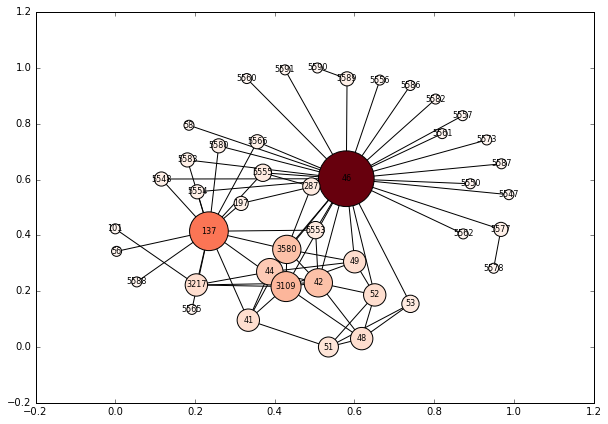

In [6]:
#Plotting graph with node size depending on degree
k = nx.degree(G)
plt.figure(1, figsize=(10,7))
coord = nx.spring_layout(G)
%time
nx.draw_networkx(G,
                 pos=coord,
                 nodelist=k.keys(),
                 node_size = [d*100 for d in k.values()],
                 font_size=8,
                 node_color=list(k.values()),
                 cmap=plt.cm.Reds,
                 )

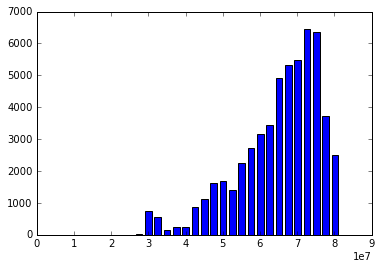

In [5]:
#Гистограмма распределения количества связей во времени
hist, bins = np.histogram(users_usa['Time'], bins=30)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [137]:
#Разбивка исходной таблицы USERS и CONTACTS на несколько подтаблиц с разным временем
new_users = users_usa.sort('Time')
index1 = pd.Series(range(0,len(new_users['Node'])))
new_users = new_users.set_index(index1)
data_users = [new_users.head(i*1000) for i in range(1,54)]
new_contacts = contacts_usa.sort('Time')
index2 = pd.Series(range(0,len(new_contacts['Node1'])))
new_contacts = new_contacts.set_index(index2)
data_contacts = [new_contacts[new_contacts['Time']<=int(data_users[i]['Time'].iloc[[-1]])] for i in range(0,53)]

/home/pavel-s/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/home/pavel-s/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [322]:
#Создание пустых графов
graph=[nx.Graph() for i in range(0,53)]

In [329]:
#Number of DataFrame or Graph
num = 4

In [330]:
#Добавление узлов в граф
graph[num].add_nodes_from([(int(data_users[num]['Node'].iloc[[i]]),
                          {'Time':int(data_users[num]['Time'].iloc[[i]]),
                           'Name':data_users[num]['Name'].iloc[[i]].values[0],
                           'City':data_users[num]['City'].iloc[[i]].values[0],
                           'Country':data_users[num]['Country'].iloc[[i]].values[0]}) for i in range(0,len(data_users[num]['Node']))])

In [331]:
#Добавление связей в граф
graph[num].add_edges_from([(int(data_contacts[num]['Node1'].iloc[[i]]),
                          int(data_contacts[num]['Node2'].iloc[[i]])) for i in range(0,len(data_contacts[num]['Node1']))])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


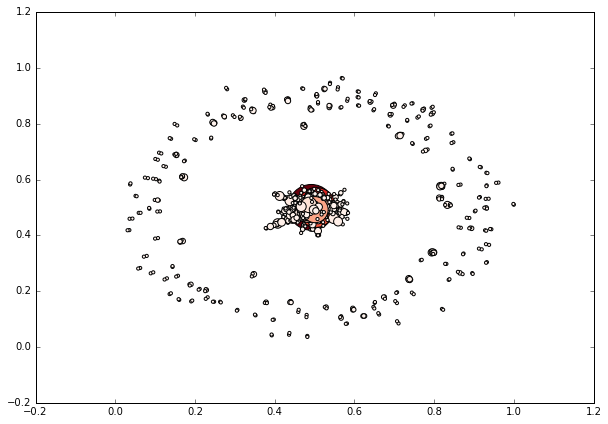

In [172]:
#Plotting graph with node size depending on degree
k = nx.degree(graph[0])
plt.figure(1, figsize=(10,7))
coord = nx.spring_layout(graph[0])
%time
nx.draw_networkx(graph[0],
                 pos=coord,
                 with_labels=0,
                 nodelist=k.keys(),
                 node_size = [d*10 for d in k.values()],
                 font_size=8,
                 node_color=list(k.values()),
                 cmap=plt.cm.Reds,
                 )

In [332]:
#Creating list of empty DataFrames for TRAIN
train = [pd.DataFrame() for i in range(0,53)]

In [333]:
#Creating design matrix
import itertools
from itertools import combinations
for_design = data_users[num-2]['Node'].tolist()
r=2
com = list(combinations(for_design, r))
train[num]=pd.DataFrame(com, columns = ['Node1','Node2'])

In [334]:
#Shortest path
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    try:
        train[num].loc[i,'Shortest_path'] = len(nx.shortest_path(graph[num-1],source,target))-1
    except nx.NetworkXNoPath:
        train[num].loc[i,'Shortest_path'] = 15000

In [335]:
#Jaccard Coefficient
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'Jaccard'] = next(nx.jaccard_coefficient(graph[num-1],((source,target),)))[2]

In [247]:
#delta Jaccard Coefficient
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'delta Jaccard'] = train[num].loc[i,'Jaccard']-next(nx.jaccard_coefficient(graph[num-2],((source,target),)))[2]

In [336]:
#Clustering coefficient
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'Cluster coef'] = sum(nx.clustering(graph[num-1],[source,target]).values())

In [248]:
#delta Clustering coefficient
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'delta Cluster coef'] = train[num].loc[i,'Cluster coef']-sum(nx.clustering(graph[num-2],[source,target]).values())

In [338]:
#Degree centrality
degree = nx.degree_centrality(graph[num-1])
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'Degree centr'] = degree.get(source)+degree.get(target)

In [269]:
#Closeness centrality
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    train[num].loc[i,'Close centr'] = nx.closeness_centrality(graph[num-1],u=source,normalized = True)+nx.closeness_centrality(graph[num-1],u=target,normalized = True)

In [233]:
#Katz score - doesn't work
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    l = map(lambda x: beta**len(x)*len(x), tuple(nx.all_simple_paths(graph[1], source, target, cutoff=4)))
    train[num].loc[i,'Katz'] = np.sum(np.power(beta, l)*l)

TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'map'

In [339]:
#Link (0 or 1)
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    if len(data_contacts[num][(data_contacts[num]['Node1'].values==source) & (data_contacts[num]['Node2'].values==target)])==1 or len(data_contacts[num][(data_contacts[num]['Node1'].values==target) & (data_contacts[num]['Node2'].values==source)])==1:
        train[num].loc[i,'Link']=1
    else:
        train[num].loc[i,'Link']=0

In [340]:
#Data Frame with data for train/test
train[num].head()

,Node1,Node2,Shortest_path,Jaccard,Cluster coef,Degree centr,Link
0,41,44,1,0.206897,0.377650,0.026257,1
1,41,46,1,0.250000,0.187889,0.071268,1
2,41,58,1,0.150000,0.311566,0.034509,1
3,41,197,1,0.145833,0.334835,0.027507,1
4,41,3217,1,0.178378,0.194384,0.054514,1


In [341]:
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(train[num][['Shortest_path','Jaccard','Cluster coef','Degree centr']], train[num][['Link']], test_size=.4)
clf = tree.DecisionTreeClassifier(random_state=1580, criterion='entropy', max_depth=4, min_samples_leaf=44)
clf.fit(X_train, y_train)
# вычисление качества предсказания на обучающей выборке
print('accuracy (train):', accuracy_score(y_train, clf.predict(X_train)))
# предсказание с помощью обученного дерева
y_pred = clf.predict(X_test)
# вычисление качества предсказания на проверочной выборке
print('accuracy (test): ', accuracy_score(y_test, y_pred))

accuracy (train): 0.999961839132
accuracy (test):  0.99995165055


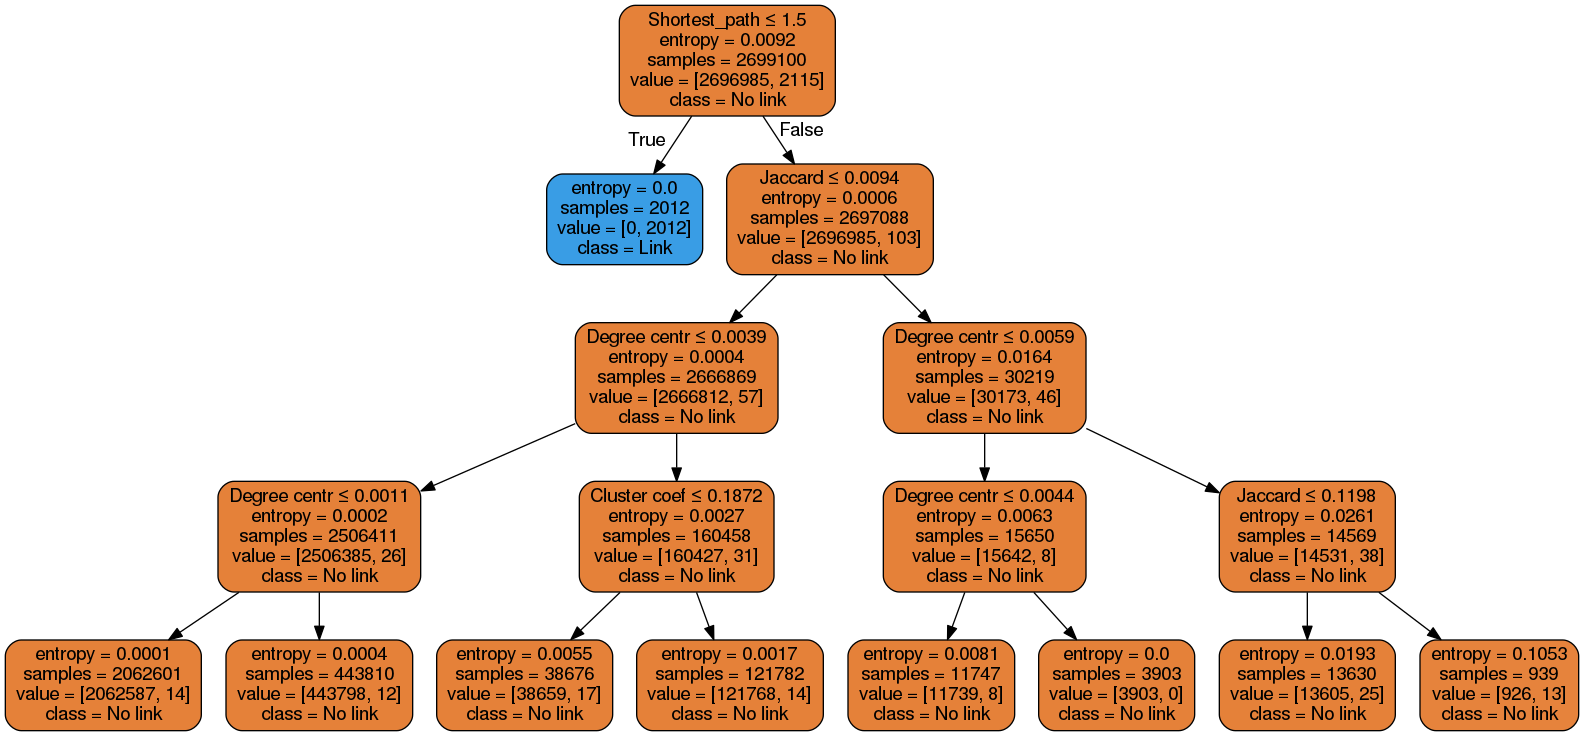

In [342]:
#Plotting tree
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=list(X_train.columns), class_names=['No link', 'Link'], filled=True, rounded=True, special_characters=True)  
graphs = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graphs.create_png())  